In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
!pip install scikit-optimize
import skopt

In [38]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys

from fun_floodestimate import FloodHeight
from fun_floodestimate import FloodHeightWall
from fun_floodestimate import FloodTravelSectGroup
from fun_floodestimate import SurfaceVolFunc
from fun_damagecost import damage

from fun_objective_loop_manywalls import objective
from fun_objective_loop_manywalls_random import objective_random_storms
#from fun_objective_loop import constraint1
#from fun_objective_loop import constraint2
#from fun_objective_loop import constraint3

#input_name = sys.argv[1]
output_name = sys.argv[1]

#x = np.loadtxt(input_name)

#ws = int(sys.argv[1])
#we = int(sys.argv[2])
#wh = float(sys.argv[3])
#wall_year = int(sys.argv[4])
#fname = sys.argv[5]

# setup
# Surface Volume Input
ndiv18 = 18
sections = [10,11,5,12,1,13,16,4,17,15,3,14,0,9,8,7,2,6]
files = glob.glob('NewSurfaceVolumeCombined/LMN_div18_*.csv') 
groupcsvfiles = glob.glob('NewSurfaceVolumeGrouped/LMN_div18_*.csv') 
H = np.append(np.linspace(0,3,13),np.linspace(3.5,7,8))

SVfg1 = np.zeros([ndiv18,2]);  SVfg2 = np.zeros([ndiv18,2]);  SVfg3 = np.zeros([ndiv18,2]);  SVfg4 = np.zeros([ndiv18,2])
SVfg5 = np.zeros([ndiv18,2]);  SVfg6 = np.zeros([ndiv18,2]);  SVfg7 = np.zeros([ndiv18,2]);  SVfg8 = np.zeros([ndiv18,2])
SVfg9 = np.zeros([ndiv18,2]);  SVfg10 = np.zeros([ndiv18,2]); SVfg11 = np.zeros([ndiv18,2]); SVfg12 = np.zeros([ndiv18,2])
SVfg13 = np.zeros([ndiv18,2]); SVfg14 = np.zeros([ndiv18,2]); SVfg15 = np.zeros([ndiv18,2]); SVfg16 = np.zeros([ndiv18,2])
SVfg17 = np.zeros([ndiv18,2]); SVfg18 = np.zeros([ndiv18,2]); SVfg19 = np.zeros([ndiv18,2]); SVfg20= np.zeros([ndiv18,2])

i = 0
for f in groupcsvfiles:
    surfaceVg = pd.read_csv(f)["volume"]
    SVfg1[i,:],SVfg2[i,:],SVfg3[i,:],SVfg4[i,:],SVfg5[i,:],SVfg6[i,:],SVfg7[i,:],SVfg8[i,:],SVfg9[i,:],SVfg10[i,:],SVfg11[i,:],SVfg12[i,:],SVfg13[i,:],SVfg14[i,:],SVfg15[i,:],SVfg16[i,:],SVfg17[i,:],SVfg18[i,:],SVfg19[i,:],SVfg20[i,:] = SurfaceVolFunc(surfaceVg,H)
    i = i + 1 


SVf1 = np.zeros([ndiv18,2]);  SVf2 = np.zeros([ndiv18,2]);  SVf3 = np.zeros([ndiv18,2]);  SVf4 = np.zeros([ndiv18,2])
SVf5 = np.zeros([ndiv18,2]);  SVf6 = np.zeros([ndiv18,2]);  SVf7 = np.zeros([ndiv18,2]);  SVf8 = np.zeros([ndiv18,2])
SVf9 = np.zeros([ndiv18,2]);  SVf10 = np.zeros([ndiv18,2]); SVf11 = np.zeros([ndiv18,2]); SVf12 = np.zeros([ndiv18,2])
SVf13 = np.zeros([ndiv18,2]); SVf14 = np.zeros([ndiv18,2]); SVf15 = np.zeros([ndiv18,2]); SVf16 = np.zeros([ndiv18,2])
SVf17 = np.zeros([ndiv18,2]); SVf18 = np.zeros([ndiv18,2]); SVf19 = np.zeros([ndiv18,2]); SVf20= np.zeros([ndiv18,2])

SV_all = []
i = 0
for f in files:
    surfaceV_height = pd.read_csv(f)
    surfaceV = surfaceV_height["volume"]
    SV_all = np.append(SV_all,surfaceV)
    SVf1[i,:],SVf2[i,:],SVf3[i,:],SVf4[i,:],SVf5[i,:],SVf6[i,:],SVf7[i,:],SVf8[i,:],SVf9[i,:],SVf10[i,:],SVf11[i,:],SVf12[i,:],SVf13[i,:],SVf14[i,:],SVf15[i,:],SVf16[i,:],SVf17[i,:],SVf18[i,:],SVf19[i,:],SVf20[i,:] = SurfaceVolFunc(surfaceV,H)
    i = i+1
SV_all = SV_all.reshape(18,21)

roughness = pd.read_csv("Roughness.csv")["Roughness"]
slope = pd.read_csv("LMN_Slope.csv")["Slope"]

# Setup - Division Connectivities
sect3 = np.zeros([len(sections)-6,7])
k = 3
for i in sections[3:-3]:
    sect3[k-3] = [sections[k-3],sections[k-2],sections[k-1],i,sections[k+1],sections[k+2],sections[k+3]]
    k = k + 1

sect0  = [sections[0],sections[1],sections[2],sections[3]] 
sect1  = [sections[0],sections[1],sections[2],sections[3],sections[4]]
sect2  = [sections[0],sections[1],sections[2],sections[3],sections[4],sections[5]]

sect_3 = [sections[-6],sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_2 = [sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_1 = [sections[-4],sections[-3],sections[-2],sections[-1]]

# initial value
total_cost = 75*10**9 # total cost without any protective measure
cost_opt   = total_cost
x_opt 	   = [0,2040,0,0]

def objective2(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

def objective3(x_input):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = int(min(x_input[1],162))
    wh = x_input[2]
    if we > ws:
        x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    return total_cost_new

def objective4(x_input):
    x = np.ones(163)*x_input
    print(x_input)
    
    
    num_iter = np.random.randint(10)
    num_iter = 1
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=num_iter)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

def damage2(h):
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    damage_cost = total_cost_new-wall_cost
    return damage_cost, wall_cost, n_cost_direct_sum_div

def objective5(x_input):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    wl = x_input[1]
    we = int(min(ws+wl,162))
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print('--------')
    print(x_input)
    print([ws,we,wh])
    #print(x)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new)
    return total_cost_new

cons3 = [{'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 162-x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: 5.0-x[2]}]




In [140]:
obj4_101 = np.zeros(101)
for i, x in enumerate(np.linspace(0,5,101)):
    obj4_101[i] = objective4(x)

0.0
0
5.56506992569983
0.05
0
5.486408940499073
0.1
0
5.45871765351906
0.15000000000000002
0
5.397853961052378
0.2
0
5.317234976466337
0.25
0
5.254975083883782
0.30000000000000004
0
5.121530221714931
0.35000000000000003
0
4.93734405837719
0.4
0
4.941760486753782
0.45
0
4.902988602858221
0.5
0
4.887710706031441
0.55
0
4.887542310158345
0.6000000000000001
0
4.857071522053774
0.65
0
4.854253769946199
0.7000000000000001
0
4.9551839975351895
0.75
0
4.969479064001318
0.8
0
5.0900784640328895
0.8500000000000001
0
4.968830172029828
0.9
0
5.024839794015937
0.9500000000000001
0
5.056031794212155
1.0
0
4.836656042531507
1.05
0
4.686315310618354
1.1
0
4.724671159881795
1.1500000000000001
0
4.744166772220007
1.2000000000000002
0
4.519428878477349
1.25
0
4.426102462702822
1.3
0
4.339512116226052
1.35
0
4.049733182524352
1.4000000000000001
0
3.8097607465910417
1.4500000000000002
0
3.7279234386438898
1.5
0
3.790831757862168
1.55
0
3.8799511536340443
1.6
0
3.8756181956422604
1.6500000000000001
0
3.6994

In [143]:
obj4_inter = lambda x : np.interp(x,np.linspace(0,5,101),obj4_101)

In [147]:
res2 = skopt.gp_minimize(objective2,
                        [(0.,5.),(0.,5.),(0.,5.),(0.,5.),(0.,5.),(0.,5.),(0.,5.),(0.,5.)],
                       n_calls = 250)

0
6.249744483477055
0
2.8381742245170942
0
4.992767380200277
0
4.576792224473382
0
6.241131778498818
0
5.931866883682977
0
3.341424632240694
0
4.4233563549746435
0
5.715793803291718
0
2.329589316019249
0
2.5527866234600203
0
5.577046577374324
0
2.8051584323385224
0
2.171843860314187
0
4.807780825814133
0
2.1101243388639706
0
2.766989907045901
0
2.4764624038300305
0
3.857523950964575
0
2.171732996073983
0
2.049113679362495
0
2.296901243815901
0
5.0389931805996975
0
2.1442721687472117
0
2.4739070625162203
0
5.259237201416267
0
2.0749120256269595
0
2.39527443045073
0
2.1382323259025275
0
2.1721189822918063
0
3.753613715100681
0
1.8912694711744993
0
2.4094411180488304
0
2.8302533322647476
0
2.998431971239149
0
2.9803827997169234
0
2.299656019038901
0
2.071188192412273
0
3.359833552016211
0
1.9842410461206088
0
2.5209558906796463
0
2.256060219380991
0
2.2586602454004994
0
1.920451288135813
0
2.076137245461122
0
2.187561638811899
0
1.9785490960980896
0
4.7261809613636245
0
2.015445602871079


In [150]:
#res2.models[0].predict()

ValueError: Expected 2D array, got 1D array instead:
array=[0.         0.05050505 0.1010101  0.15151515 0.2020202  0.25252525
 0.3030303  0.35353535 0.4040404  0.45454545 0.50505051 0.55555556
 0.60606061 0.65656566 0.70707071 0.75757576 0.80808081 0.85858586
 0.90909091 0.95959596 1.01010101 1.06060606 1.11111111 1.16161616
 1.21212121 1.26262626 1.31313131 1.36363636 1.41414141 1.46464646
 1.51515152 1.56565657 1.61616162 1.66666667 1.71717172 1.76767677
 1.81818182 1.86868687 1.91919192 1.96969697 2.02020202 2.07070707
 2.12121212 2.17171717 2.22222222 2.27272727 2.32323232 2.37373737
 2.42424242 2.47474747 2.52525253 2.57575758 2.62626263 2.67676768
 2.72727273 2.77777778 2.82828283 2.87878788 2.92929293 2.97979798
 3.03030303 3.08080808 3.13131313 3.18181818 3.23232323 3.28282828
 3.33333333 3.38383838 3.43434343 3.48484848 3.53535354 3.58585859
 3.63636364 3.68686869 3.73737374 3.78787879 3.83838384 3.88888889
 3.93939394 3.98989899 4.04040404 4.09090909 4.14141414 4.19191919
 4.24242424 4.29292929 4.34343434 4.39393939 4.44444444 4.49494949
 4.54545455 4.5959596  4.64646465 4.6969697  4.74747475 4.7979798
 4.84848485 4.8989899  4.94949495 5.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

AssertionError: Space dimension must be 1

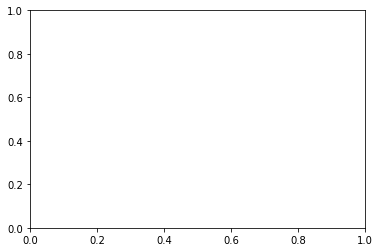

In [148]:
for n_iter in range(20):
    # Plot true function.
    plt.figure()

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res2, n_calls=n_iter,
    #                           objective=obj4_inter,
                               noise_level=0,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False,
                               n_points=30)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

In [41]:
print(res.x)
print(res.fun)
print(res.models)

[4.8809147271020885, 2.7690065306572977, 3.501871316761767, 1.7377130814565833, 1.9909733475426354, 1.9819490542392124, 2.1295326889423554, 1.6016765814574887]
2036028901.1027477
[GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=964754802), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=964754802), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kern

In [46]:
x_vals_array = np.array(res.x_iters)
print(x_vals_array.shape)

(250, 8)


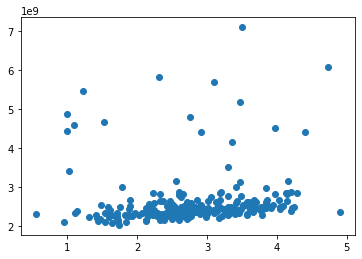

In [60]:
plt.scatter(x_vals_array[:,3],res.func_vals)

In [28]:
skopt.gp_minimize(objective5,[(0,163),(0,163),(0.0,5.0)])

--------
[116, 38, 4.715890128136785]
[116, 154, 4.715890128136785]
0
6161793428.155461
--------
[123, 30, 1.0324853595714736]
[123, 153, 1.0324853595714736]
0
5490322002.626556
--------
[79, 46, 0.5280148430552607]
[79, 125, 0.5280148430552607]
0
5640717483.098128
--------
[149, 71, 4.463912557430495]
[149, 162, 4.463912557430495]
0
5807874875.708273
--------
[157, 131, 4.11551294788967]
[157, 162, 4.11551294788967]
0
5655426628.757284
--------
[70, 90, 1.0148011161712243]
[70, 160, 1.0148011161712243]
0
5115216041.428655
--------
[147, 151, 4.289988745658737]
[147, 162, 4.289988745658737]
0
5835763253.96409
--------
[127, 75, 0.0839616978151997]
[127, 162, 0.0839616978151997]
0
5541500199.004737
--------
[44, 147, 1.3352930482676142]
[44, 162, 1.3352930482676142]
0
5227935120.369131
--------
[26, 57, 2.84328378953008]
[26, 83, 2.84328378953008]
0
6338847037.746229
--------
[70, 90, 1.0148012309138943]
[70, 160, 1.0148012309138943]
0
5115216089.105917


C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--------
[70, 90, 1.014801109654109]
[70, 160, 1.014801109654109]
0
5115216038.720698
--------
[70, 90, 1.5082999129710182]
[70, 160, 1.5082999129710182]
0
5333483043.0149765
--------
[70, 90, 1.5892360099671234]
[70, 160, 1.5892360099671234]
0
5398408333.382565
--------
[70, 90, 0.1645551172862268]
[70, 160, 0.1645551172862268]
0
5408413396.359295
--------
[70, 90, 1.0696489420746977]
[70, 160, 1.0696489420746977]
0
5139413962.322458
--------
[72, 90, 1.1181041336662785]
[72, 162, 1.1181041336662785]
0
5012089387.447827
--------
[71, 90, 0.5624632483331603]
[71, 161, 0.5624632483331603]
0
5045930877.205095
--------
[81, 90, 1.152958799227639]
[81, 162, 1.152958799227639]
0
5033510985.266023
--------
[77, 90, 0.43463012243361404]
[77, 162, 0.43463012243361404]
0
5034417158.049694
--------
[68, 90, 0.49537769625369177]
[68, 158, 0.49537769625369177]
0
5289279602.11479
--------
[74, 90, 0.8320273991941645]
[74, 162, 0.8320273991941645]
0
4869036305.966594
--------
[65, 90, 0.280719095588

KeyboardInterrupt: 

In [30]:
skopt.gp_minimize(objective5,[(0,163),(0,163),(0.0,5.0)])

--------
[50, 134, 3.149338057493569]
[50, 162, 3.149338057493569]
0
6113084108.038067
--------
[33, 145, 1.7110405509719198]
[33, 162, 1.7110405509719198]
0
5424911840.082595
--------
[133, 73, 1.0868711467955314]
[133, 162, 1.0868711467955314]
0
5386342160.333633
--------
[127, 80, 4.330957359069659]
[127, 162, 4.330957359069659]
0
5638337867.38897
--------
[136, 104, 1.16849360755484]
[136, 162, 1.16849360755484]
0
5573660979.133811
--------
[115, 110, 3.59391643330681]
[115, 162, 3.59391643330681]
0
5544862260.808804
--------
[120, 85, 3.3221340234443026]
[120, 162, 3.3221340234443026]
0
5477636310.306984
--------
[54, 96, 2.319160077432529]
[54, 150, 2.319160077432529]
0
6061748631.784087
--------
[19, 156, 3.696232424256035]
[19, 162, 3.696232424256035]
0
6899429934.446518
--------
[28, 116, 4.560381823522046]
[28, 144, 4.560381823522046]
0
7582466767.43894
--------
[120, 92, 4.633417773952875]
[120, 162, 4.633417773952875]
0
5748666073.213101
--------
[127, 82, 2.644985923051963

--------
[132, 96, 1.9545393045565216]
[132, 162, 1.9545393045565216]
0
5386272501.188297
--------
[133, 142, 1.9506165113417375]
[133, 162, 1.9506165113417375]
0
5509611407.285772
--------
[132, 100, 1.9522318820755078]
[132, 162, 1.9522318820755078]
0
5385931842.562891
--------
[133, 86, 1.9482243172204834]
[133, 162, 1.9482243172204834]
0
5509270005.780197
--------
[132, 62, 1.9498695741932748]
[132, 162, 1.9498695741932748]
0
5385583080.8763895
--------
[133, 94, 1.9457769690485291]
[133, 162, 1.9457769690485291]
0
5508920732.975306
--------
[132, 107, 1.9476353328043094]
[132, 162, 1.9476353328043094]
0
5385253226.414688
--------
[133, 89, 1.943189424779186]
[133, 162, 1.943189424779186]
0
5508551452.112415


          fun: 5273920296.819723
    func_vals: array([6.11308411e+09, 5.42491184e+09, 5.38634216e+09, 5.63833787e+09,
       5.57366098e+09, 5.54486226e+09, 5.47763631e+09, 6.06174863e+09,
       6.89942993e+09, 7.58246677e+09, 5.74866607e+09, 5.34794278e+09,
       5.32969737e+09, 5.38224580e+09, 5.32041636e+09, 5.37825700e+09,
       5.27392030e+09, 5.30031609e+09, 5.31850958e+09, 5.34568119e+09,
       5.42792637e+09, 5.41992875e+09, 5.36715225e+09, 5.36616469e+09,
       5.36198076e+09, 5.35959839e+09, 5.34839899e+09, 5.34660079e+09,
       5.37897190e+09, 5.34923485e+09, 5.34392608e+09, 5.34260583e+09,
       5.34138224e+09, 5.34020691e+09, 5.33914966e+09, 5.33812605e+09,
       5.33714339e+09, 5.33621245e+09, 5.33531177e+09, 5.33444536e+09,
       5.33360047e+09, 5.40025221e+09, 5.39970408e+09, 5.41252766e+09,
       5.39897574e+09, 5.39835231e+09, 5.39782154e+09, 5.39729820e+09,
       5.39677818e+09, 5.39625924e+09, 5.39574029e+09, 5.39522616e+09,
       5.39470593e+09, 5.3942

In [122]:
res4 = skopt.gp_minimize(objective4,
                         [(0.0,5.0)],
                         acq_func="EI",
                         n_calls=30,
                         n_random_starts=5,
                         noise=0.01)

[4.518745607503323]
0
3.624737094034192
[3.8148717328546784]
0
3.0601207237910835
[1.2150748090027665]
0
4.492667132947355
[4.256029084457726]
0
3.4139975638606375
[0.45805959428081416]
0
4.8950343440127035
[3.224172734084765]
0
2.5862882140134054
[2.8936686223093417]
0
2.3367257110155664
[2.681827638448056]
0
2.3392589671536825
[2.7414721880929056]
0
2.233372083900777
[2.555312027586277]
0
2.190379045616238
[2.4795144692347955]
0
2.174194914713317
[2.4490861253629093]
0
2.156516969174504
[2.412320195657021]
0
2.2491775816558723
[2.512763010994642]
0
2.0852195382442615
[2.2902655999105197]
0
2.2012670745668004
[2.3095785347601288]
0
2.2169770997732603
[2.510943704625646]
0
2.08413265290594
[2.511858315408034]
0
2.084678802946763
[2.511703969414131]
0
2.084586599301672
[2.5114272953032497]
0
2.0844213543446966
[2.511053942628067]
0
2.0841984395096453
[2.5105772801184774]
0
2.083914151871396
[2.5103199303949224]
0
2.083760818068232
[2.5098954024183144]
0
2.083508075007292
[2.509762384929

In [123]:
res4.x_iters

[[4.518745607503323],
 [3.8148717328546784],
 [1.2150748090027665],
 [4.256029084457726],
 [0.45805959428081416],
 [3.224172734084765],
 [2.8936686223093417],
 [2.681827638448056],
 [2.7414721880929056],
 [2.555312027586277],
 [2.4795144692347955],
 [2.4490861253629093],
 [2.412320195657021],
 [2.512763010994642],
 [2.2902655999105197],
 [2.3095785347601288],
 [2.510943704625646],
 [2.511858315408034],
 [2.511703969414131],
 [2.5114272953032497],
 [2.511053942628067],
 [2.5105772801184774],
 [2.5103199303949224],
 [2.5098954024183144],
 [2.5097623849294286],
 [2.5088686509013627],
 [2.508586355740581],
 [2.507788226404335],
 [2.4598889164714928],
 [2.550990344395139]]

C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


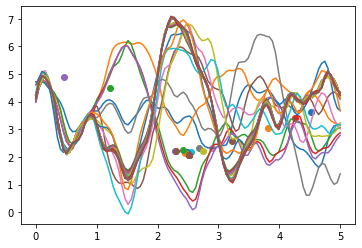

In [152]:
for i in range(len(res4.models)):
    X = np.linspace(0,5,100)
    plt.scatter(res4.x_iters[i],res4.func_vals[i])
    plt.plot(X,res4.models[i].sample_y(X.reshape(-1, 1)))
    
plt.show()

In [155]:
res4.models[3]

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.01, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=2012120129)

In [158]:
GPRlist = res4.copy()

In [191]:
GPR = GPRlist['models'][3]

In [192]:
s = GPR.fit(np.array(res4.x_iters[-1]).reshape(-1, 1),np.array(res4.func_vals[-1]).reshape(-1, 1))

In [193]:
y= GPR.predict(X.reshape(-1, 1),s)


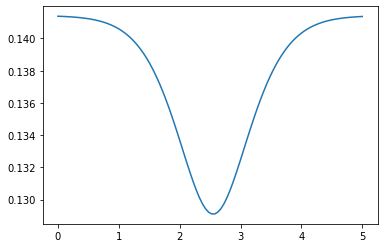

In [194]:
plt.plot(X,y[1])

In [167]:
res4.x_iters

[[4.518745607503323],
 [3.8148717328546784],
 [1.2150748090027665],
 [4.256029084457726],
 [0.45805959428081416],
 [3.224172734084765],
 [2.8936686223093417],
 [2.681827638448056],
 [2.7414721880929056],
 [2.555312027586277],
 [2.4795144692347955],
 [2.4490861253629093],
 [2.412320195657021],
 [2.512763010994642],
 [2.2902655999105197],
 [2.3095785347601288],
 [2.510943704625646],
 [2.511858315408034],
 [2.511703969414131],
 [2.5114272953032497],
 [2.511053942628067],
 [2.5105772801184774],
 [2.5103199303949224],
 [2.5098954024183144],
 [2.5097623849294286],
 [2.5088686509013627],
 [2.508586355740581],
 [2.507788226404335],
 [2.4598889164714928],
 [2.550990344395139]]

In [121]:
X = np.linspace(0.5,4,100)
len(res4.models)

21

In [125]:
res4copy = res4.copy()

In [103]:
res4.models[0].predict(np.linspace(0.5,4,100).reshape(-1, 1))

array([3.46304472e+09, 3.46402724e+09, 3.46539738e+09, 3.46689323e+09,
       3.46858235e+09, 3.47056066e+09, 3.47268571e+09, 3.47478094e+09,
       3.47678665e+09, 3.47870222e+09, 3.48046722e+09, 3.48200425e+09,
       3.48327494e+09, 3.48428139e+09, 3.48505147e+09, 3.48562444e+09,
       3.48604108e+09, 3.48633835e+09, 3.48654708e+09, 3.48669167e+09,
       3.48679067e+09, 3.48685776e+09, 3.48690283e+09, 3.48693288e+09,
       3.48695276e+09, 3.48696584e+09, 3.48697440e+09, 3.48697997e+09,
       3.48698358e+09, 3.48698591e+09, 3.48698740e+09, 3.48698836e+09,
       3.48698897e+09, 3.48698936e+09, 3.48698961e+09, 3.48698977e+09,
       3.48698986e+09, 3.48698993e+09, 3.48698997e+09, 3.48698999e+09,
       3.48699001e+09, 3.48699002e+09, 3.48699002e+09, 3.48699003e+09,
       3.48699003e+09, 3.48699003e+09, 3.48699003e+09, 3.48699003e+09,
       3.48699003e+09, 3.48699003e+09, 3.48699003e+09, 3.48699003e+09,
       3.48699003e+09, 3.48699003e+09, 3.48699003e+09, 3.48699003e+09,
      

In [83]:
res4.x

[2.2453794596974093]

In [64]:
from skopt.plots import plot_gaussian_process

In [138]:
newfun = lambda x : 2+0.1*(x-2)**2

C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


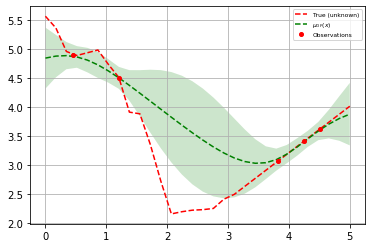

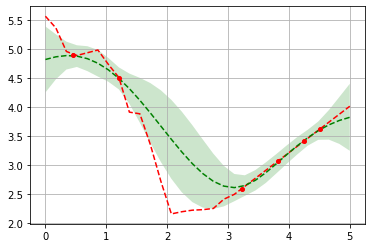

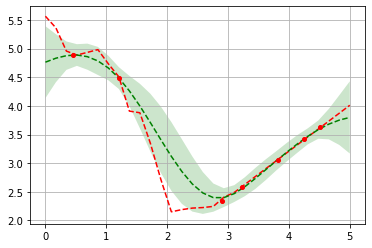

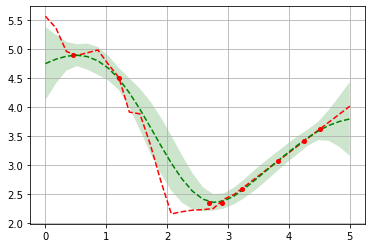

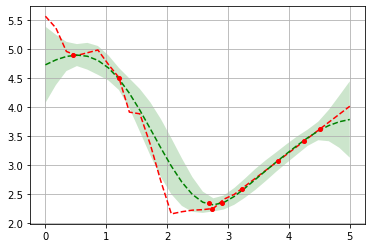

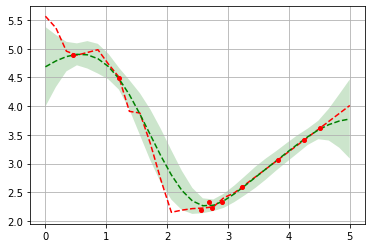

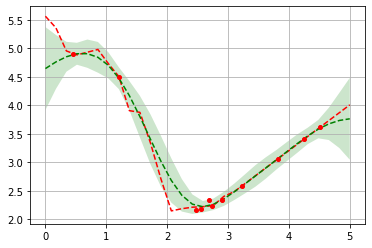

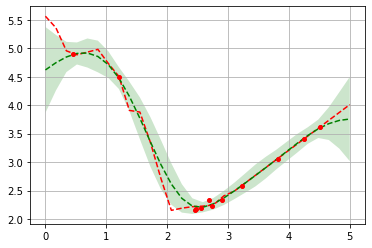

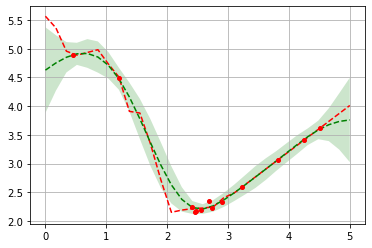

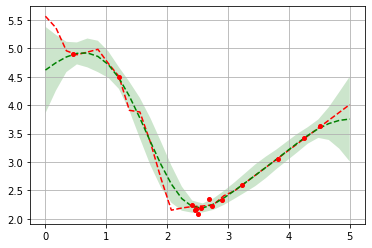

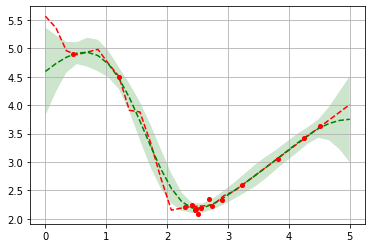

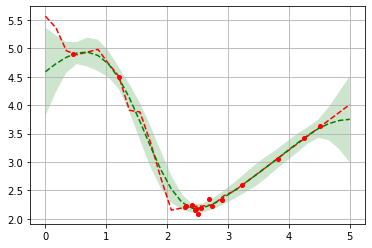

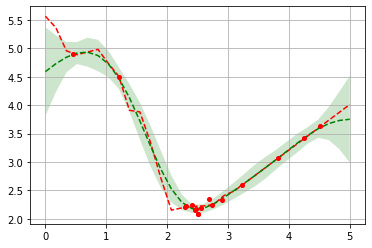

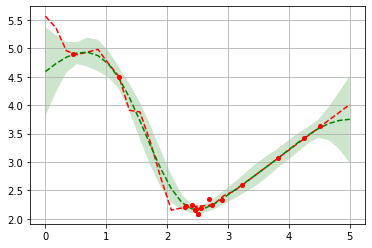

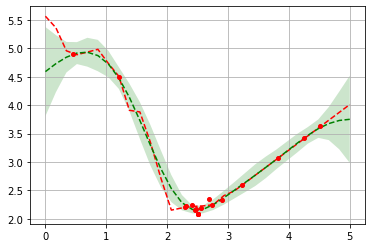

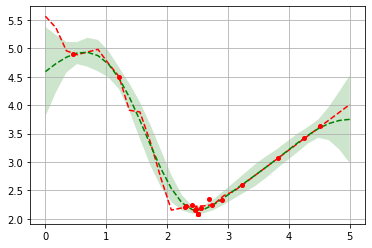

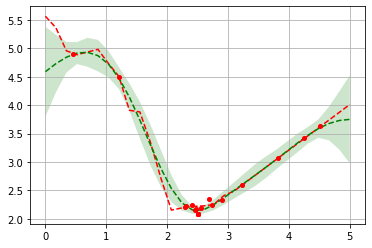

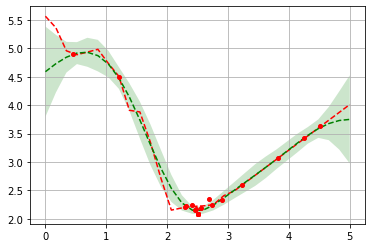

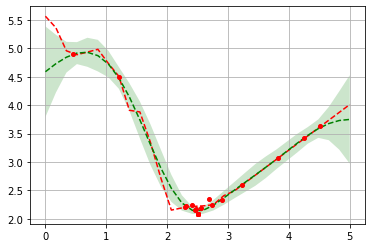

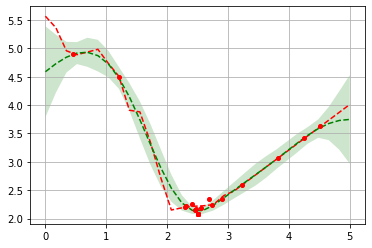

In [145]:
for n_iter in range(20):
    # Plot true function.
    #plt.subplot(5, 2, 2*n_iter+1)
    plt.figure()

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res4, n_calls=n_iter,
                               objective=obj4_inter,
                               noise_level=0,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False,
                               n_points=30)
    #ax.set_ylabel("")
    #ax.set_xlabel("")
    # Plot EI(x)
    #plt.subplot(5, 2, 2*n_iter+2)
    #plt.figure()
    #ax = plot_gaussian_process(res4, n_calls=n_iter,
    #                           show_legend=show_legend, show_title=False,
    #                           show_mu=False, show_acq_func=True,
    #                           show_observations=False,
    #                           show_next_point=True,
    #                           n_points=30)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

In [75]:
res4.x

[2.0804645401605466]

In [13]:
objective2([1,1,1,1,1,1,1,1,1])

0
4836656042.531507


4836656042.531507

In [17]:
objective3([85,15,3.15])

[85, 15, 3.15]
0


5565069925.69983

In [240]:
X_train = res2.x_iters.copy()

In [241]:
y_train = res2.func_vals.copy()

In [205]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

3.53**2 * RBF(length_scale=1.42)

In [220]:
x_opt = (res2.x).copy()
print(x_opt)
print(res2.fun)

[3.2687253766155515, 1.8039208442832713, 2.9035802422449515, 1.6200833446016525, 1.4627162361677573, 1.3080887633766016, 5.0, 1.0524189281894356]
1.60660741803422


In [222]:
x_opt

[3.2687253766155515,
 1.8039208442832713,
 2.9035802422449515,
 1.6200833446016525,
 1.4627162361677573,
 1.3080887633766016,
 5.0,
 1.0524189281894356]

C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


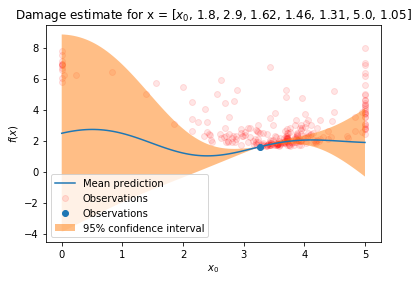

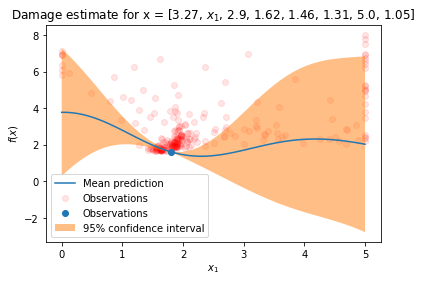

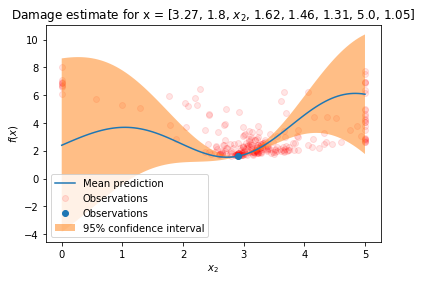

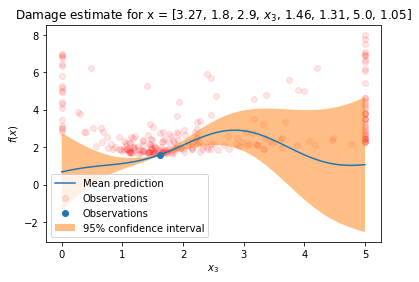

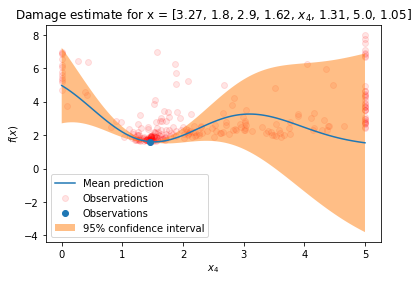

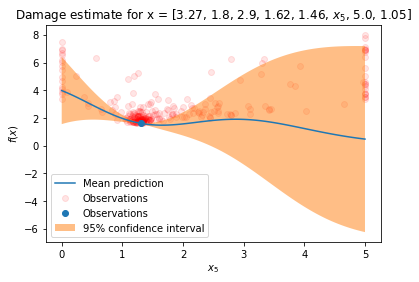

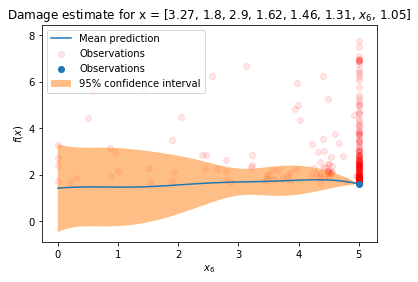

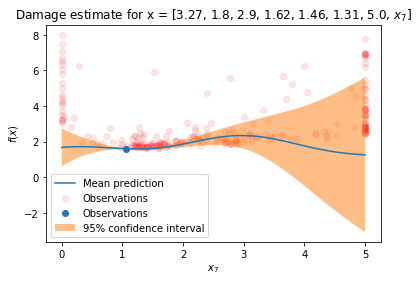

In [263]:
for change_index in range(8):
    plt.figure()
    X_to_pred = np.zeros((101,8))
    for i, x in enumerate(np.linspace(0,5.0,101)):
        X_to_pred[i,:] = x_opt.copy()
        X_to_pred[i,change_index] = x


    mean_prediction, std_prediction = gaussian_process.predict(X_to_pred, return_std=True)


    all_X = np.array(X_train)
    all_y = np.array(y_train)

    #plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
    plt.scatter(all_X[:,change_index], all_y, label="Observations",color = 'red',alpha = 0.1)
    plt.scatter(x_opt[change_index], res2.fun, label="Observations")
    plt.plot(np.linspace(0,5.0,101), mean_prediction, label="Mean prediction")
    plt.fill_between(
        X_to_pred[:,change_index].ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    plt.xlabel("$x_" +str(change_index)+"$")
    plt.ylabel("$f(x)$")
    
    title = '['
    for j in range(8):
        if j == change_index:
            title = title + '$x_'+str(j)+'$'
        else:
            title = title + str(np.around(x_opt[j],decimals = 2))
        if j < 7:
            title = title + ', '
    title = title +']'
    plt.title("Damage estimate for x = "+title)
plt.show()

In [254]:
np.round(np.array(x_opt)*1000)/1000

array([3.269, 1.804, 2.904, 1.62 , 1.463, 1.308, 5.   , 1.052])

In [238]:
str(np.array([2.3,2,4]))[9:11]

'4.'

In [265]:
for i in range(3):
    objective2([0.2]*8)

0
5.317234976466337
0
5.317234976466337
0
5.317234976466337


In [10]:
hs = np.linspace(0.0,5.0,11)
dc_array = np.zeros((len(hs),len(hs)))
wc_array = np.zeros((len(hs),len(hs)))
ds_list = []
for i, h_0 in enumerate(hs):
    for j, h_1 in enumerate(hs):
        h_array = np.array([3.269, 1.804, 2.904, 1.62 , 1.463, 1.308, 5.   , 1.052])
        h_array[0] = h_0
        h_array[1] = h_1
        dc, wc, ds = damage2(h_array)
        dc_array[i,j] = dc
        wc_array[i,j] = wc
        ds_list.append(ds)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


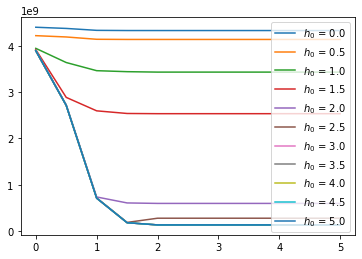

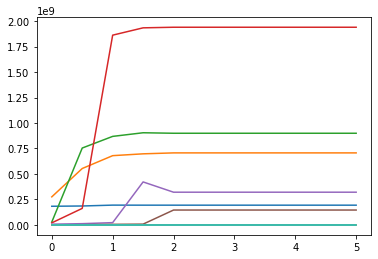

In [16]:
for i, h_0 in enumerate(hs):
    plt.plot(hs,dc_array[i,:],label = '$h_0$ = ' + str(h_0))
plt.legend()


plt.figure()
for i, h_0 in enumerate(hs):
    if i > 0:
        plt.plot(hs,dc_array[i-1,:]-dc_array[i,:],label = '$f('+str(hs[i-1])+',\\cdot) - f('+str(hs[i])+',\\cdot)$')
#plt.legend()

plt.show()

In [19]:
ds_list_np = np.array(ds_list)
print(ds_list_np.shape)

(121, 1, 18, 1)


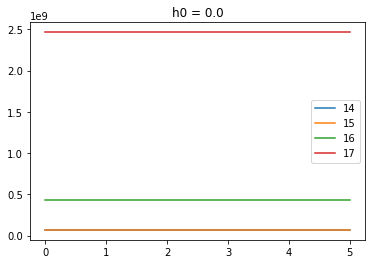

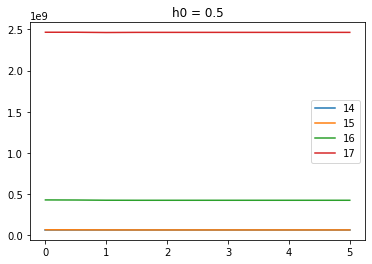

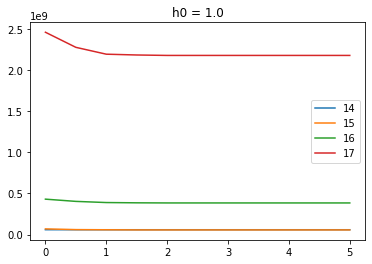

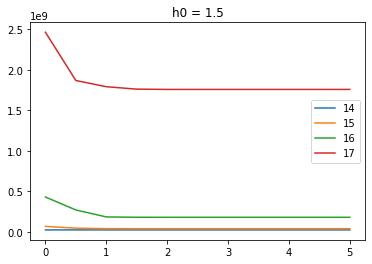

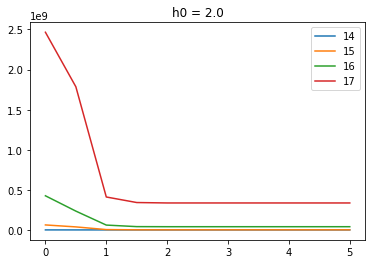

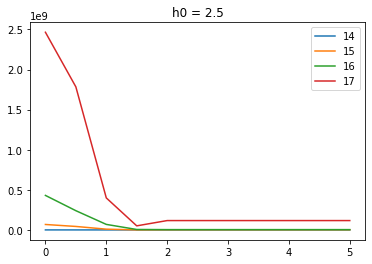

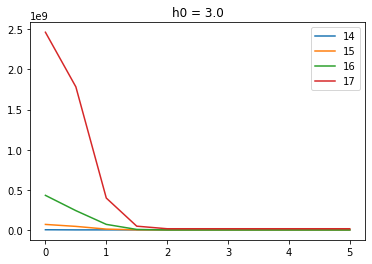

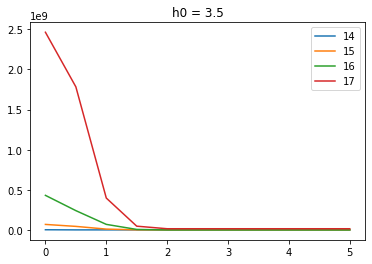

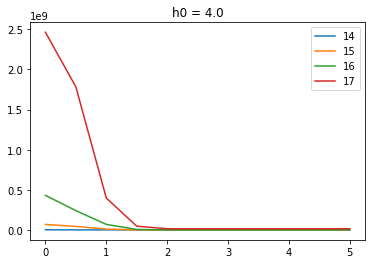

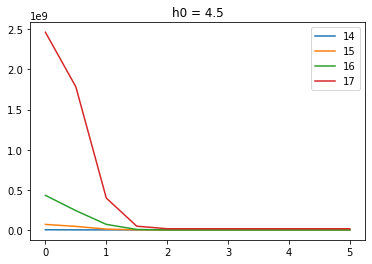

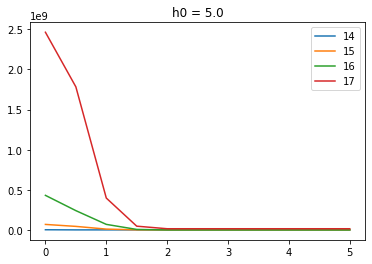

In [29]:
for i, h_0 in enumerate(hs):
    plt.figure()
    for div in range(14,18):
        plt.plot(hs,ds_list_np[(11*i):(11*i+11),0,div,0], label = str(div))
        plt.legend()
        plt.title('h0 = '+str(h_0))
plt.show()

In [31]:
ds_array = np.zeros((len(hs),len(hs),18))
for i in range(len(hs)):
    for j in range(len(hs)):
        ds_array[i,j,:] = ds_list_np[11*i+j,0,:,0] 

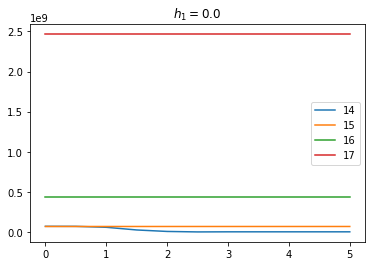

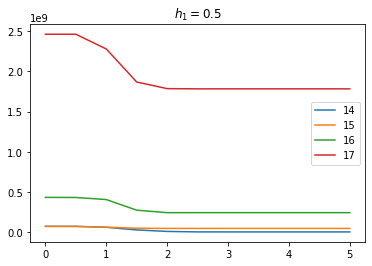

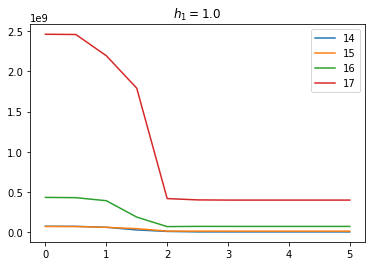

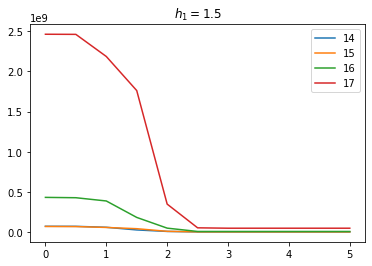

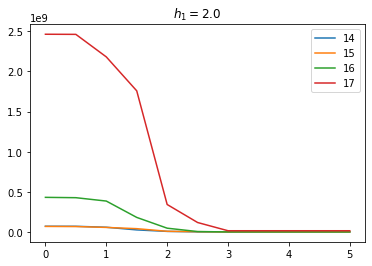

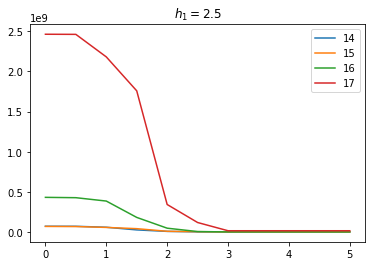

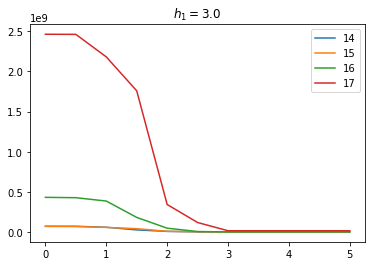

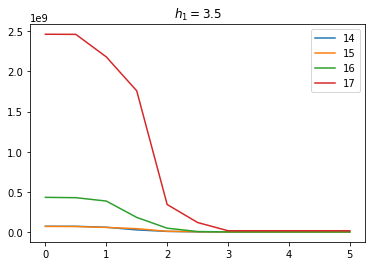

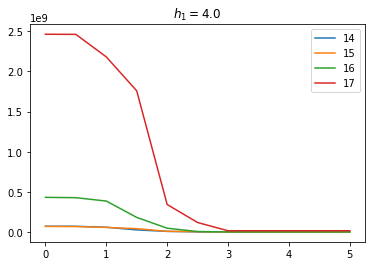

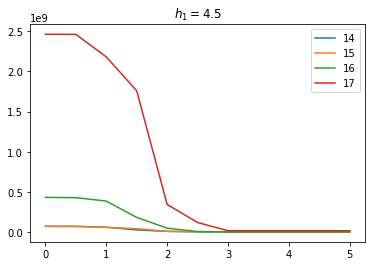

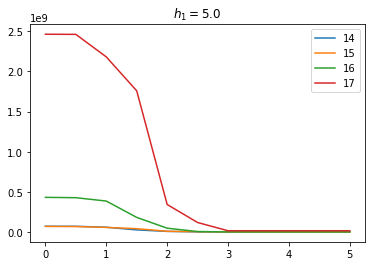

In [37]:
for j, h_1 in enumerate(hs):
    plt.figure()
    for div in range(14,18):
        plt.plot(hs,ds_array[:,j,div], label = str(div))
        plt.legend()
        plt.title('$h_1 = '+str(h_1)+'$')
plt.show()